#  Introduction #

Today I will be analyzing a datset containing various video games. The goal:
- Determine if there are patterns that determine if a game is successful or not

If I am able to detect such patterns, this is will aid in predicting successful games for upcoming new seasons and thus strategically plan advertisting campaigns around them.

### Precursory Data Analysis and Cleaning ##

First I will load the necessary libraries and take my first look into the dataset.


In [1]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats as st
import math as math
from matplotlib import pyplot as plt



In [2]:
#preliminary look into the data
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
#checking for duplicates
games.duplicated().sum()

0

From a quick glance I can see that I'm missing values in the Name, Year of Release, Genre, Critic Score, User Score, and Ratings Column. There are no  100% duplicated rows. I will start by making all the columns lowercase and converting columns to the correct data type.
Upon further investigation I see that the User Score column is classified as a object due to over 2000 rows having 'tbd' as the input value.

In [6]:
games.columns= games.columns.str.lower()

## Missing Values  and Data Type Conversion ###

### User Score ###

In [7]:
len(games.query('user_score.str.contains("tbd")==1'))

2424

As mentioned above there are 'tbd' values for over 2000 of the rows. I will change the tbd values to NaN to then change the column to a float type.

In [8]:
games['user_score']=games['user_score'].replace('tbd','NaN').astype('float')

In [9]:
len(games.query('user_score.isna() == True'))

9125

In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


### Name ###

In [11]:
games.query('name.isna() == True')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [12]:
len(games.query('name.isna() == True'))/games.shape[0]

0.00011965300628178283

Looking at the above there would be no way in filling in the missing Name values with what little information we have. And because these two rows make up such a small portion of the dataframe, I will drop them. 

In [13]:
games = games.drop([659,14244])

In [14]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


### Year of Release ###

The dataset includes the platform these games were released on. As time goes on, fewer and fewer games get released on older gaming consoles, in favor of new ones. With that in mind, I will group the missing values by gaming consoles and then determine if I want to use the median or the mean to input as their Year of Release. 

In [15]:
games.query('year_of_release.isna() == True')['platform'].value_counts()

Wii     34
PS2     34
X360    30
DS      30
PS3     25
XB      21
PC      17
2600    17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
GB       1
PSV      1
Name: platform, dtype: int64

I've chosen to go with the median to fill in the missing values as it would give me a number without decimals.

In [16]:
fill_med_year= games.groupby('platform')['year_of_release'].median()

In [17]:
def getstats(row):
    if np.isnan(row['year_of_release']):
        return fill_med_year.get(row['platform'])
    else:
        return row['year_of_release']
    

In [18]:
games['year_of_release']=games.apply(getstats, axis=1)

In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


### Genre ###

It does not look as if the genre column is missing any values and the data type is correct, so no changes will be made here.

### The Sales Columns ###

It looks as if all the sales columns are not missing any values and they have the correct data type so no changes will be done to those columns. I will later on add a total sales columns calculating the sum of each row taking into account all of its' region sales.

### Critic Score ###

In [20]:
len(games.query('critic_score.isna() == True'))/games.shape[0]

0.5131334889008556

The missing critic score rows take up over 50% of the corresponding dataset. 

In [21]:
games.query('critic_score.isna() == True')['year_of_release'].sort_values().value_counts()

2009.0    802
2010.0    764
2008.0    733
2011.0    645
2007.0    505
2006.0    386
2015.0    381
1998.0    354
2012.0    332
2014.0    320
1999.0    302
2005.0    295
2013.0    277
1997.0    273
2016.0    270
1996.0    255
1995.0    219
2000.0    207
2004.0    203
2002.0    202
2003.0    196
2001.0    156
1994.0    120
1993.0     60
1982.0     53
1981.0     46
1992.0     42
1991.0     41
1986.0     21
1983.0     17
1989.0     17
1990.0     16
1987.0     16
1988.0     14
1984.0     14
1985.0     13
1980.0      9
Name: year_of_release, dtype: int64

I orignally believed that perhaps the older consoles did not have critic scores available to them because they were older, but looking at the above it seems like even newer games (like those released in 2015 or 2016) having missing values for critic scores. It is also possible that certain games didn't catch on in popularity enough to warrant a critic's review or some games weren't very popular in certain countries.

As mentioned above, the missing values make up over 50% of the dataset. This is too large a portion to try to replace accurately so I will leave them as is.

### Users Revisited ###

In [22]:
games['user_score'].isna().sum()/games.shape[0]

0.5458625022437623

Similarly with the critics score, the user scores make up almost 55% of the dataset. This is a very large portion and I would not be able to fill in the all of the missing values without potentially affecting the accuracy of the dataset.

### Adding a Total Sales Column ###

In [23]:
def total_sales(row):
    sales = 0
    sales += (row['na_sales'] + row['eu_sales']+ row['jp_sales']+row['other_sales'])
    return sales

In [24]:
games['total_sales']=games.apply(total_sales,axis=1)

In [25]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Ratings ###
To attempt to fill in the missing ratings I will change the current rating system into numbers to make it easier to work with:
- E: 8
- M: 7
- T: 6
- E10+: 5
- K-A: 4
- AO: 3 
- EC: 2
- RP: 1

There are a few instances where a game has been released on several platforms but is missing a rating for one of them (i.e. Ratatouille), as ratings do not change depending on the platform, I will use those values to fill in the missing ones. 

In [26]:
games.query('name == "Ratatouille"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1598,Ratatouille,DS,2007.0,Action,0.49,0.62,0.0,0.14,NaN,NaN,NaN,1.25
2442,Ratatouille,PS2,2007.0,Action,0.31,0.00,0.0,0.53,65.0,8.0,E,0.84
3069,Ratatouille,PSP,2007.0,Action,0.22,0.27,0.0,0.16,64.0,7.1,E,0.65
3902,Ratatouille,PS3,2007.0,Action,0.09,0.32,0.0,0.10,55.0,4.8,E,0.51
3948,Ratatouille,Wii,2007.0,Action,0.43,0.03,0.0,0.04,62.0,6.7,E,0.50
6398,Ratatouille,X360,2007.0,Action,0.23,0.02,0.0,0.02,56.0,NaN,E,0.27
7681,Ratatouille,GBA,2007.0,Action,0.14,0.05,0.0,0.00,65.0,NaN,E,0.19
9015,Ratatouille,GC,2007.0,Action,0.11,0.03,0.0,0.00,60.0,5.6,E,0.14
14514,Ratatouille,PC,2007.0,Action,0.01,0.01,0.0,0.00,NaN,7.9,E,0.02


In [27]:
games['rating'].isna().sum()/games.shape[0]

0.40471489259857596

In [28]:
games.query('rating.isna()==True').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67


In [29]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [30]:
rate_mode=games.groupby('name')['rating']

In [31]:
def replace_rating(value):
    if value == 'E':
        return 8
    if value == 'M':
        return 7
    if value == 'T':
        return 6
    if value == 'E10+':
        return 5
    if value == 'K-A':
        return 4
    if value == 'AO':
        return 3
    if value =='EC':
        return 2
    if value =='RP':
        return 1

In [32]:
games['rating']=games['rating'].apply(replace_rating)

In [33]:
games['rating'].astype('float')

0        8.0
1        NaN
2        8.0
3        8.0
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: rating, Length: 16713, dtype: float64

In [34]:
fill_rating= games.groupby('name')['rating'].median()

In [35]:
def getrat(row):
    if np.isnan(row['rating']):
        return fill_rating.get(row['name'])
    else:
        return row['rating']

In [36]:
games['rating']=games.apply(getrat, axis=1)

In [37]:
games['rating'].isna().sum()/games.shape[0]

0.37856758212170166

With the function I was able to decrease the missing values of the ratings column from about 40% to 38%.

### Conclusion ###

Above I filled a portion of the missing values found in the Score, Year of Release, and Ratings columns. 
I changed the score column to a float type to make it easier to work with and after changing the tbd's found in the user score to NaN, I changed that column as well to a float type.
I also created a column to tally up the total sales for a row.
I believe the missing values can stem from possibly a game being older and thus critic/user scores weren't collected or maintained through the years. Another possible reason is that the dataset is simply incomplete, in that case I would ask the one's that provided me with the dataset is there is a more complete/up-to-date version.

## Analysis #

To move forward with our analysis, I will have to determine what period of the dataset I will be working with in order to build a prognosis for 2017. First I will investigate the number of games released each year to see if there is significant data for every period. I will make sure to only count unique entries for games. Even if a game is released on multiple platforms, at the end of the day, the company still essentially released 1 game. 

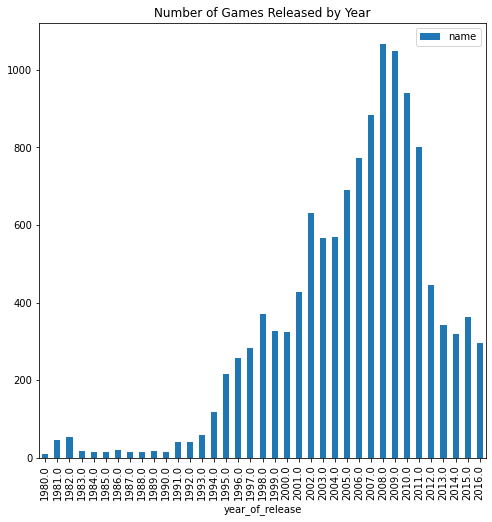

In [38]:
games_count= games.pivot_table(index='year_of_release', values='name', aggfunc=pd.Series.nunique).plot(kind='bar',figsize=(8,8))
plt.title('Number of Games Released by Year')
plt.show()

The first time over 500 games were released was in 2002, with a peak of 1067 games released in 2008. Afterwards though the amount of games released declines over the years. 

#### Platform Sales ####

Next I will investigate platform sales, starting with determining how sales have varied from platform to platform.

In [39]:
total_plat_sales = games.pivot_table(index='platform', values='total_sales',aggfunc='sum')
total_plat_sales.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


I will take the top 5 platforms (PS2, X360, PS3, Wii, and DS) and find the distribution over the years for sales. 

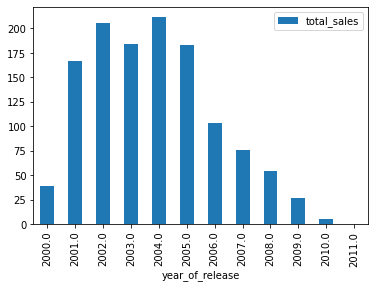

In [40]:
#PS2 Distribution

ps2_sales= games.query('platform == "PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

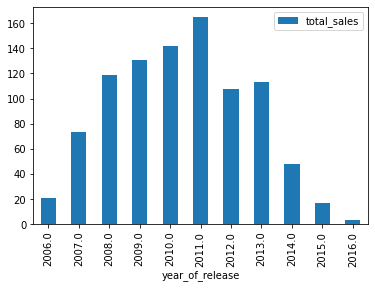

In [41]:
#PS3 Distribution
ps3_sales= games.query('platform == "PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

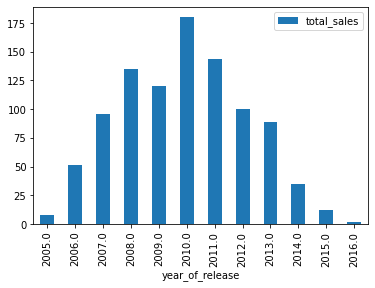

In [42]:
#X360 Distribution
x360_sales= games.query('platform == "X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

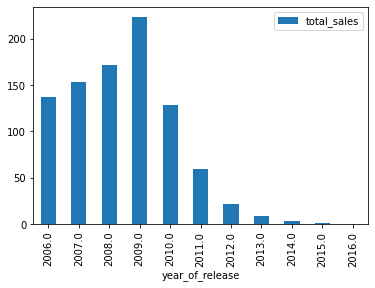

In [43]:
#Wii Distribution
wii_sales= games.query('platform == "Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

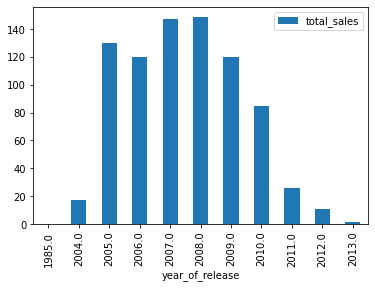

In [44]:
#DS distribution
ds_sales= games.query('platform == "DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

I will compare the above platforms with a few of the lower performing platforms (DC, N64, XOne).

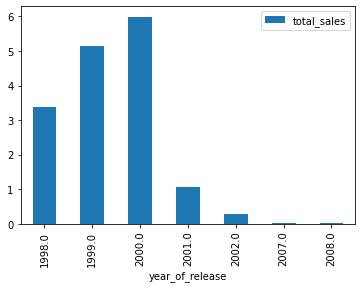

In [45]:
#DC Distribution
dc_sales= games.query('platform == "DC"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

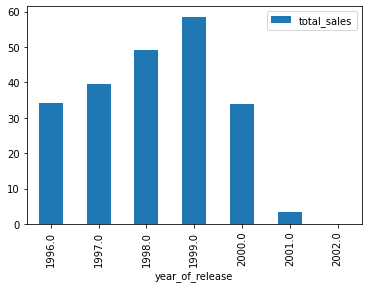

In [46]:
#N64 Distribution
n64_sales= games.query('platform == "N64"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

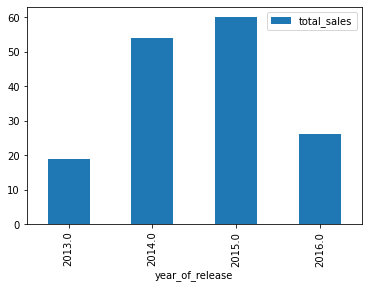

In [47]:
#XOne distribution
xone_sales= games.query('platform == "XOne"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar')
plt.show()

In these lower performing platforms we can see that they had a few years of sales before fizzling out and having 0 sales. 
Even the popular consoles show a simialr pattern of great sales in the early years of their cycle before losing popularity and having sales drop to almost 0. It seems like the newer game consoles have a life span of about 10 years, during the latter portion of that period, a newer version of the console is introduced and sales drop for the older console (i.e. Ps2 vs Ps3). 

With that being said, as my goal is to have a prognosis for 2017, I will be looking at data starting from the year 2011.

In [48]:
filtered_games= games.query('year_of_release > 2010')

In [49]:
filtered_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4056 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             4056 non-null   object 
 1   platform         4056 non-null   object 
 2   year_of_release  4056 non-null   float64
 3   genre            4056 non-null   object 
 4   na_sales         4056 non-null   float64
 5   eu_sales         4056 non-null   float64
 6   jp_sales         4056 non-null   float64
 7   other_sales      4056 non-null   float64
 8   critic_score     1831 non-null   float64
 9   user_score       2052 non-null   float64
 10  rating           2519 non-null   float64
 11  total_sales      4056 non-null   float64
dtypes: float64(9), object(3)
memory usage: 411.9+ KB


In [50]:
filtered_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,7.0,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,7.0,16.27
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,7.0,14.73
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60


I will now investigate sale trends for my new filtered dataset

In [51]:
filt_total_sales = filtered_games.pivot_table(index='platform',values='total_sales',aggfunc='sum')
filt_total_sales.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS3,453.88
X360,380.38
PS4,314.14
3DS,259.00
XOne,159.32
PC,97.68
Wii,95.02
WiiU,82.19
PSV,54.07


In [52]:
filt_total_sales2 = filtered_games.pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum')
filt_total_sales2

platform,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,,
2011.0,63.20,26.18,35.03,0.45,165.09,NaN,17.82,4.63,59.65,NaN,143.84,NaN
2012.0,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013.0,57.76,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014.0,43.76,NaN,13.28,NaN,47.76,100.00,0.24,12.16,3.75,22.03,34.74,54.07
2015.0,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016.0,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


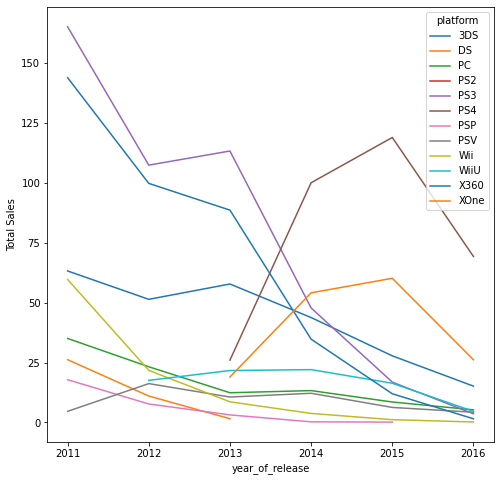

In [53]:
filt_total_sales2.plot(figsize=(8,8))
plt.ylabel('Total Sales')

plt.show()

Based on the above graph I can see that consoles such as Wii, 3DS, PS3, and X360 are shrinking, while PS4 and XOne are growing. This points to the PS4 and XOne being potentially profitable platforms.

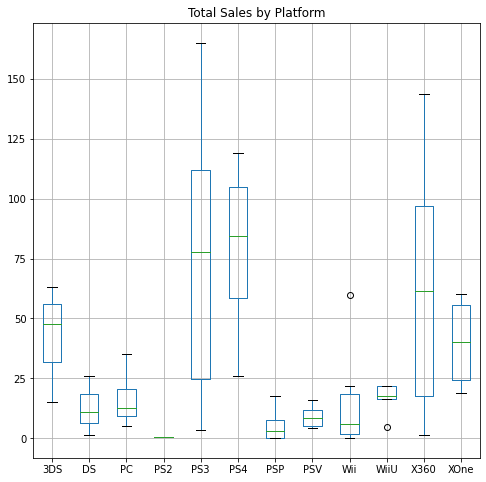

In [54]:
filt_total_sales2.boxplot(figsize=(8,8))
plt.title('Total Sales by Platform')
plt.show()

There is quite a difference between the platforms in terms of global sales. The PS4 has the highest average of global sales with the PS3 coming in second. PS2 and PSP have the lowest average global sales.

#### Reviews and Sales ####

Next I will investigate whether and how user and critic scores affect sales. For this portion of the analysis I will be focusing solely on PS3 sales.

In [55]:
ps3_filter = filtered_games.query('platform == "PS3"')
ps3_filter

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,7.0,21.05
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,7.0,13.79
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,7.0,13.33
69,Call of Duty: Ghosts,PS3,2013.0,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,7.0,9.36
81,FIFA Soccer 13,PS3,2012.0,Action,1.06,5.01,0.13,1.97,88.0,6.6,8.0,8.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16628,Akatsuki no Goei Trinity,PS3,2012.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16638,Tour de France 2014,PS3,2014.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,8.0,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014.0,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


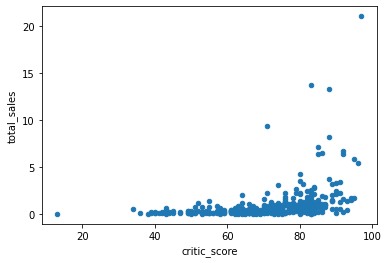

In [56]:
ps3_filter.plot(x='critic_score',y='total_sales', kind='scatter')
plt.show()

In [57]:
ps3_filter['critic_score'].corr(ps3_filter['total_sales'])

0.3797253577883183

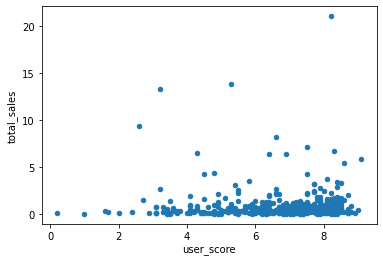

In [58]:
ps3_filter.plot(x='user_score',y='total_sales', kind='scatter')
plt.show()

In [59]:
ps3_filter['user_score'].corr(ps3_filter['total_sales'])

0.01252143035253283

The linear correlation between critic scores and sales is weak and the same can be said for user scores and sales. 

#### Comparing Game Sales on Different Platforms ####

I will take the top 5 grossing games and compare the sales of those games on different platforms. I will exlude games that are solely available on the Wii as my aim is to investigate different platforms and I've already determined that Wii sales are shrinking.

In [60]:
top_games=filtered_games.pivot_table(index='name',values='total_sales',aggfunc='sum')
top_games.sort_values(by='total_sales', ascending=False).head(10)

,total_sales
name,
Grand Theft Auto V,56.58
Call of Duty: Modern Warfare 3,30.60
Call of Duty: Black Ops II,29.40
Call of Duty: Ghosts,27.39
Call of Duty: Black Ops 3,25.67
Minecraft,24.16
Call of Duty: Advanced Warfare,21.97
The Elder Scrolls V: Skyrim,21.14
FIFA 15,17.37


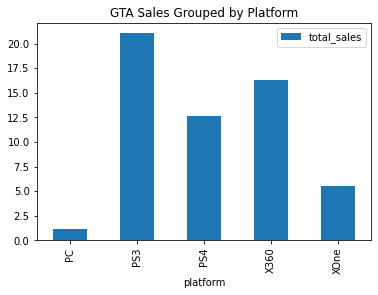

In [61]:
#GTA
gta_plot = filtered_games.query('name=="Grand Theft Auto V"').pivot_table(index='platform',values='total_sales', aggfunc='sum').plot(kind='bar')
plt.title('GTA Sales Grouped by Platform')
plt.show()

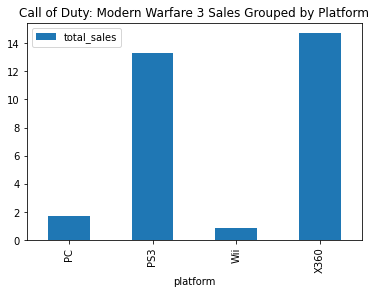

In [62]:
#Call of Duty: Modern Warfare 3
codmw3_plot = filtered_games.query('name=="Call of Duty: Modern Warfare 3"').pivot_table(index='platform',values='total_sales', aggfunc='sum').plot(kind='bar')
plt.title('Call of Duty: Modern Warfare 3 Sales Grouped by Platform')
plt.show()

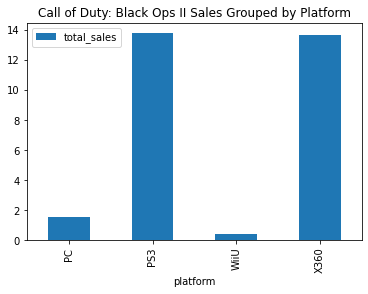

In [63]:
#Call of Duty: Black Ops II
codbo_plot = filtered_games.query('name=="Call of Duty: Black Ops II"').pivot_table(index='platform',values='total_sales', aggfunc='sum').plot(kind='bar')
plt.title('Call of Duty: Black Ops II Sales Grouped by Platform')
plt.show()

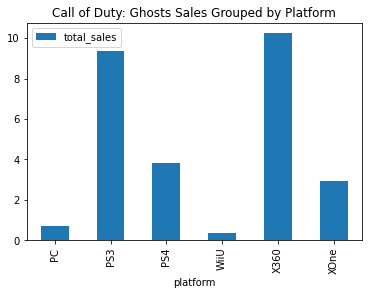

In [64]:
#Call of Duty: Ghosts
codg_plot = filtered_games.query('name=="Call of Duty: Ghosts"').pivot_table(index='platform',values='total_sales', aggfunc='sum').plot(kind='bar')
plt.title('Call of Duty: Ghosts Sales Grouped by Platform')
plt.show()

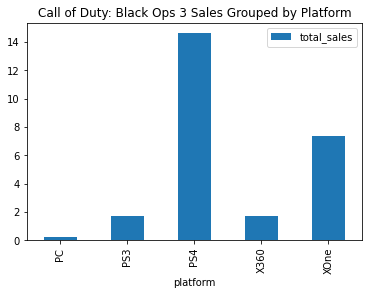

In [65]:
#Call of Duty: Black Ops 3
codbo2_plot = filtered_games.query('name=="Call of Duty: Black Ops 3"').pivot_table(index='platform',values='total_sales', aggfunc='sum').plot(kind='bar')
plt.title('Call of Duty: Black Ops 3 Sales Grouped by Platform')
plt.show()

For the top grossing games (that are not available exclusively on the Wii), it seems like the most profit can be seen when the games are on PS3 and X360. Note: This could also be related to the year of the release for these top grossing games as seen by Black Ops 3 being more profitable on the PS4 and XboxOne.

#### Sales and Genre ####

In [66]:
filtered_games['genre'].nunique()

12

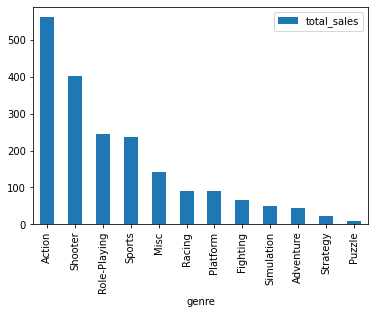

In [67]:
genre_plot=filtered_games.pivot_table(index='genre',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False).plot(kind='bar')
plt.show()

It seems that the most profitable genre is Action, followed by Shooter. The least profitable genre seems to be puzzle. I would hesitate to generalize about top grossing and least grossing genres beyond this dataset as there's always the possibility of a game from one of the other categories being a surprise best seller. Also as these are total sales, it may hide any discrepancies when the data is broken up by region.

## Creating Profiles ##

As the dataset includes sales for North America, Europe, and Japan, I will analyze these regions individually to find the top platforms, genres, and to determine if ESRB ratings affect sales. 

### North America ###

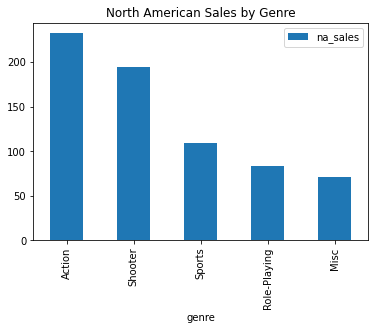

In [68]:
top_genre_na=filtered_games.pivot_table(index='genre',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).head().plot(kind='bar')
top_genre_na
plt.title('North American Sales by Genre')
plt.show()

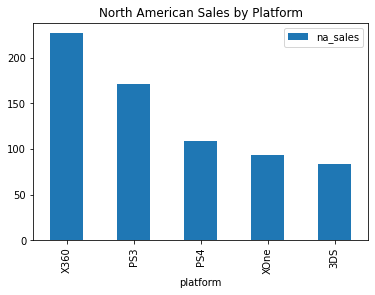

In [69]:
top_plat_na=filtered_games.pivot_table(index='platform',values='na_sales',aggfunc='sum').sort_values(by='na_sales',ascending=False).head().plot(kind='bar')
top_plat_na
plt.title('North American Sales by Platform')
plt.show()

In [70]:
print(
filtered_games.query('platform =="X360"')['na_sales'].sum()/filtered_games['na_sales'].sum(),
filtered_games.query('platform =="PS3"')['na_sales'].sum()/filtered_games['na_sales'].sum(),
filtered_games.query('platform =="PS4"')['na_sales'].sum()/filtered_games['na_sales'].sum(),
filtered_games.query('platform =="XOne"')['na_sales'].sum()/filtered_games['na_sales'].sum(),
filtered_games.query('platform =="3DS"')['na_sales'].sum()/filtered_games['na_sales'].sum()
)

0.2719196230532209 0.20576210629803254 0.1303727504885681 0.11164530554989388 0.10009951203136427


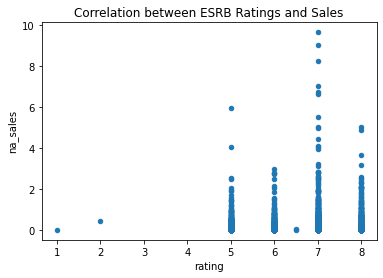

In [71]:
filtered_games.plot(x='rating',y='na_sales', kind='scatter')
plt.title('Correlation between ESRB Ratings and Sales')
plt.show()

In [72]:
filtered_games['rating'].corr(filtered_games['na_sales'])

0.06119614438605666

### Europe ###

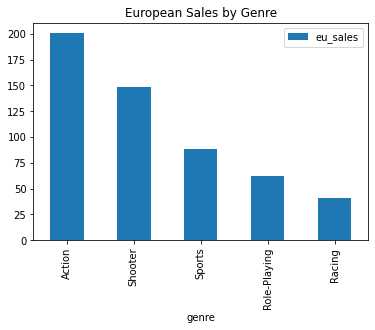

In [73]:
top_genre_eu=filtered_games.pivot_table(index='genre',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).head().plot(kind='bar')
top_genre_eu
plt.title('European Sales by Genre')
plt.show()

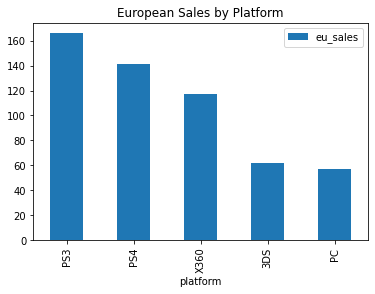

In [74]:
top_plat_eu=filtered_games.pivot_table(index='platform',values='eu_sales',aggfunc='sum').sort_values(by='eu_sales',ascending=False).head().plot(kind='bar')
top_plat_eu
plt.title('European Sales by Platform')
plt.show()

In [75]:
print(
filtered_games.query('platform =="PS3"')['eu_sales'].sum()/filtered_games['eu_sales'].sum(),
filtered_games.query('platform =="PS4"')['eu_sales'].sum()/filtered_games['eu_sales'].sum(),
filtered_games.query('platform =="X360"')['eu_sales'].sum()/filtered_games['eu_sales'].sum(),
filtered_games.query('platform =="3DS"')['eu_sales'].sum()/filtered_games['eu_sales'].sum(),
filtered_games.query('platform =="PC"')['eu_sales'].sum()/filtered_games['eu_sales'].sum()
)

0.24687653202204626 0.20960289988560904 0.17396342459851738 0.09133451190706104 0.08423335759808656


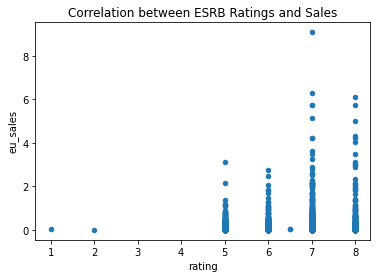

In [76]:
filtered_games.plot(x='rating',y='eu_sales', kind='scatter')
plt.title('Correlation between ESRB Ratings and Sales')
plt.show()


In [77]:
filtered_games['rating'].corr(filtered_games['eu_sales'])

0.08290196698826131

### Japan ###

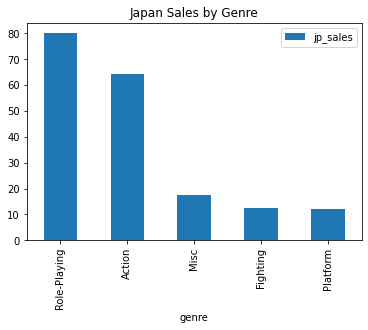

In [78]:
top_genre_jp=filtered_games.pivot_table(index='genre',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).head().plot(kind='bar')
top_genre_jp
plt.title('Japan Sales by Genre')
plt.show()

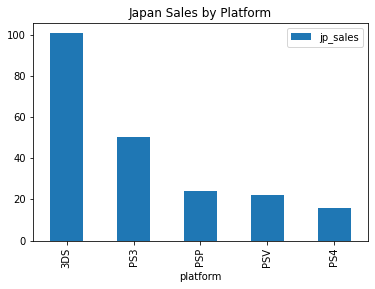

In [79]:
top_plat_jp=filtered_games.pivot_table(index='platform',values='jp_sales',aggfunc='sum').sort_values(by='jp_sales',ascending=False).head().plot(kind='bar')
top_plat_jp
plt.title('Japan Sales by Platform')
plt.show()

In [80]:
print(
filtered_games.query('platform =="3DS"')['jp_sales'].sum()/filtered_games['jp_sales'].sum(),
filtered_games.query('platform =="PS3"')['jp_sales'].sum()/filtered_games['jp_sales'].sum(),
filtered_games.query('platform =="PSP"')['jp_sales'].sum()/filtered_games['jp_sales'].sum(),
filtered_games.query('platform =="PSV"')['jp_sales'].sum()/filtered_games['jp_sales'].sum(),
filtered_games.query('platform =="PS4"')['jp_sales'].sum()/filtered_games['jp_sales'].sum(),

)

0.4083147434597444 0.20348813628067328 0.09750557696207665 0.08886635570878118 0.06473331981342527


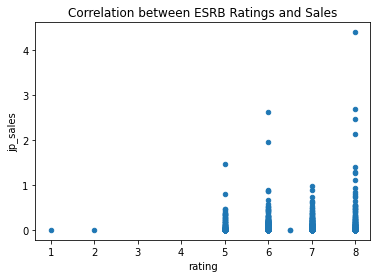

In [81]:
filtered_games.plot(x='rating',y='jp_sales', kind='scatter')
plt.title('Correlation between ESRB Ratings and Sales')
plt.show()

In [82]:
filtered_games['rating'].corr(filtered_games['jp_sales'])

0.045534256600295316

### Conclusions ###

The top 5 Genres for the regions are as followed:


NA : Action, Shooter, Sports, Role Playing, and Misc.


Europe: Action, Shooter, Sports, Role Playing, and Racing


Japan: Role Playing, Action, Misc, Fighting, and Platform

The top 5 Platforms for the regions are as followed:
NA: X630, PS3, PS4, XONE, 3DS
Europe: PS3, PS4, X360, 3DS, PC
Japan: 3DS, PS3, PSP, PSV, PS4

North America's top platform, X360 holds 27% of the market, Europe's top platform, PS3 holds 24%, and Japan's top, 3DS holds 40% of the market. 

North America and Europe both have the same top genre of Action but for Japan the top genre is Role Playing. 

There does not seem to be a linear correlation between ESRB ratings and sales in any of the regions.

## Hypothesis Testing ##

I will test 2 hypotheses:

- Average user ratings of the Xbox One and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

The null hypothesis is always formulated as the mean of x = the mean of y and the alternative hypothesis in this case will be that it is not equal. As I'm not interested in knowing if it may be larger or smaller, a two tailed hypothesis test will do.
I will choose 0.05 as the alpha level as that is conventional.

In [83]:
# Test the hypotheses
"""H0: The average user ratings of the Xbox One platform is equal to the average user ratings of 
the PC platform.
Ha: The average user ratings of the Xbox One platform is not equal to the average user ratings of 
the PC platform.

"""

xone_score=filtered_games.query('platform =="XOne"')['user_score']
pc_score= filtered_games.query('platform =="PC"')['user_score']

p_value_levene = st.levene(xone_score.dropna(), pc_score.dropna())
print(p_value_levene)
print(xone_score.mean())
print(pc_score.mean())
alpha = 0.05

results = st.ttest_ind(xone_score, pc_score,equal_var=True,nan_policy='omit')
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

LeveneResult(statistic=5.516327585628806, pvalue=0.019238606822499546)
6.521428571428572
6.451791530944625
p-value:  0.6267602271422398
We can't reject the null hypothesis


In the above t-test I used equal_var = True as I couldn't reject the null hypothesis of the Levene test. 
The t-test returned a p-value that tells us there is a 22% chance of randomly getting a difference of user score means as extreme or larger than what we have. This is too high of a probability to state that there is a statistical difference between Xbox One User scores and PC user scores. 

In [84]:
# Test the hypotheses
"""H0: The average user ratings for the Action genre is equal to the average user ratings of 
the Sports genre.
Ha: The average user ratings for the Action genre is not equal to the average user ratings of 
the Sports genre.

"""

action_score=filtered_games.query('genre =="Action"')['user_score']
sports_score= filtered_games.query('genre =="Sports"')['user_score']

p_value_levene = st.levene(action_score.dropna(), sports_score.dropna())
print(p_value_levene)
print(action_score.mean())
print(sports_score.mean())
alpha = 0.05

results = st.ttest_ind(action_score, sports_score,equal_var=False,nan_policy='omit')
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

LeveneResult(statistic=19.00725647931513, pvalue=1.4497763498209219e-05)
6.782712369597615
5.656275303643724
p-value:  5.774852186972399e-19
We reject the null hypothesis


In the above t-test the Levene test resulted in a very small p-value so I set the equal_var to False. The resulting t-test returned a p-value that is less than my chosen alpha level. Though the means looks almost the same, there is very little chance of getting a difference that extreme or larger. This means there is a statistical difference between the mean user score of the Action genre and the Sport genre. I will reject the null hypotheis.

# Conclusion #

I set out to determine if there is a pattern that can point to whether or not a game will be commercially successful. 
In my intial data cleaning, I added a column for total sales, filled in missing critic and user scores where possible and filled in missing release year dates. I changed the data type of the rating column and changed the individual ratings to numbers to aid in analysis and in filling in missing values. I also changed all the column names to lowercase.

From there I sought to find which data period was best suited to come up with a prognosis for 2017. To do so I look at sales across platforms and how many games were released each year. I found that the lifespan of a game console tended to be about 10 years, with a newer version being released in the latter portion of those years. I then chose to move forward with data that was from 2007 or later. 

Using this filtered data I analyzed which platforms were shrinking. I also found which were growing (PS4 and Xbox One). Despite this it seems that PS3 and Xbox360 had the highest average total sales of the filtered data set. 
There was a medium positive linear correlation between critic scores and total sales sales. 

Whether there is a pattern to whether a game is successful will depend on the region, as each region has different top platforms and genres. Japan's top is the DS and roleplaying, Europe's is the PS3 and action, and North America's is the Xbox360 and action. Prior to creating an advertisting campaign I would keep those regional differences in mind. 